In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
import sqlite3
conn = sqlite3.connect('FPA_FOD_20170508.sqlite')
df = pd.read_sql_query("SELECT * from Fires", conn)

# targets:

/Users/avikogan/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


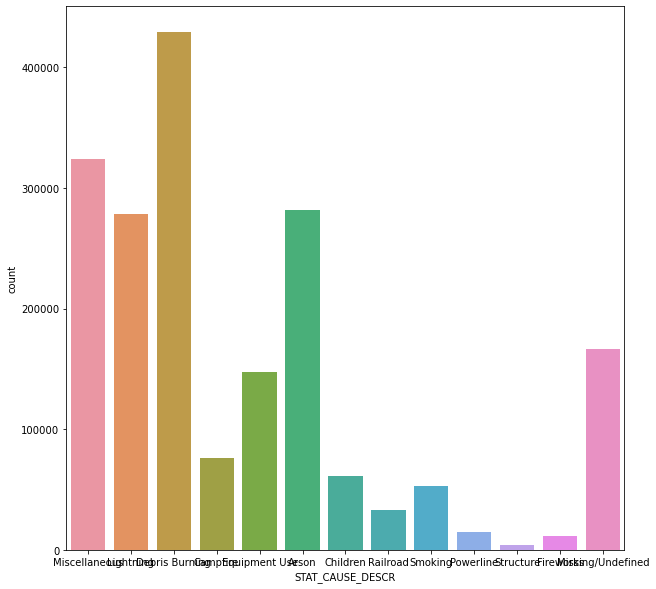

In [6]:
plt.figure(figsize=(10,10))
sns.countplot('STAT_CAUSE_DESCR' ,data=df)
plt.show()

The target is unbalanced

# 'LONGITUDE' 'LATITUDE'

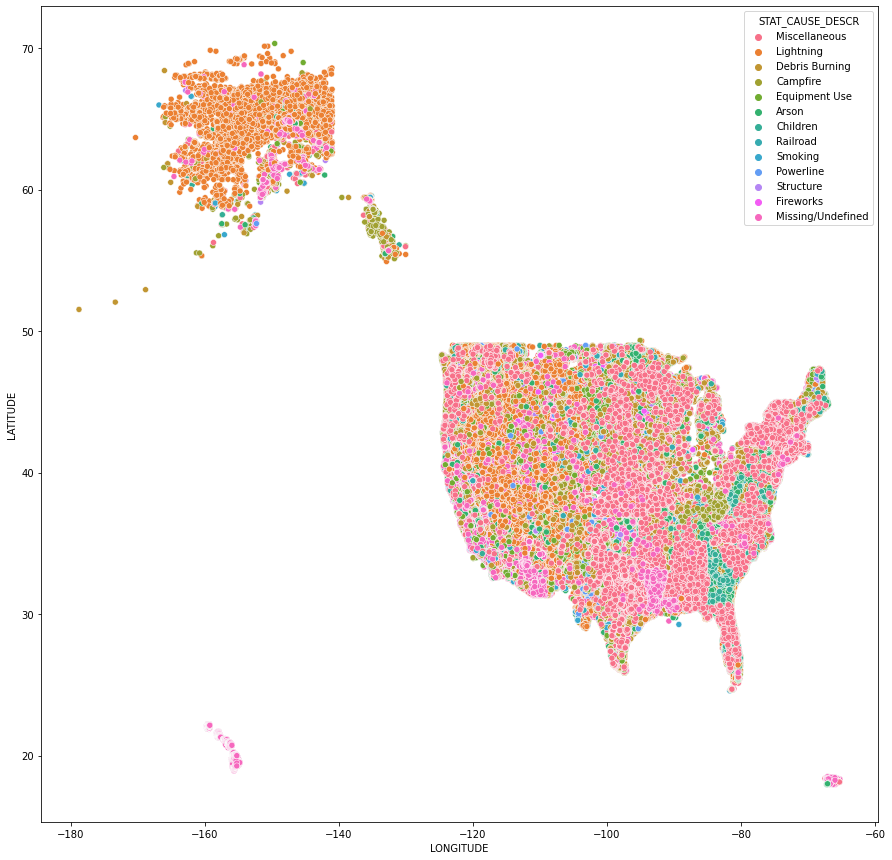

In [5]:
plt.figure(figsize=(15,15))
sns.scatterplot(x='LONGITUDE', y='LATITUDE', hue='STAT_CAUSE_DESCR', data=df)
plt.show()

We can see that the geographical location can help understand the cause of the fire

# 'FIRE_YEAR'

/Users/avikogan/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Years distribution')]

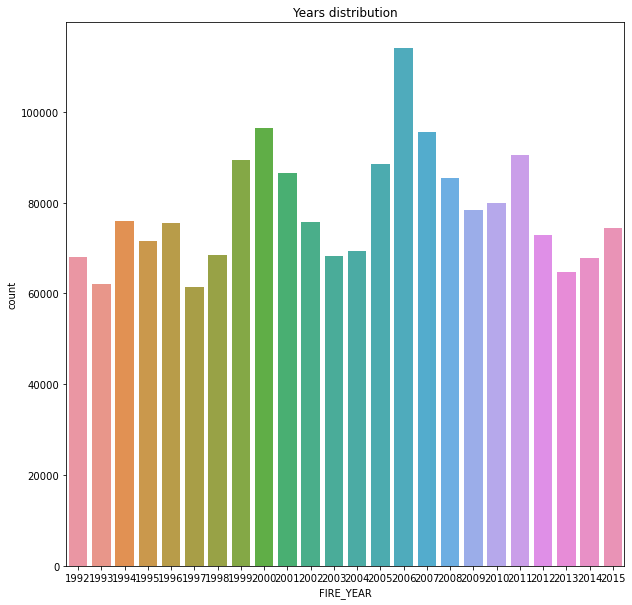

In [12]:
plt.figure(figsize=(10,10))
sns.countplot('FIRE_YEAR', data=df).set(title="Years distribution")

## DISCOVERY_DATE 

In [8]:
df['DISCOVERY_DATE'].head(2) # Julian dates, need to convert

0    2453403.5
1    2453137.5
Name: DISCOVERY_DATE, dtype: float64

In [9]:
df['DISCOVERY_DATE_CONVERT'] = pd.to_datetime(df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')

df['DISCOVERY_MONTH'] = df['DISCOVERY_DATE_CONVERT'].apply(lambda x: x.month)
df['DISCOVERY_DAY'] = df['DISCOVERY_DATE_CONVERT'].apply(lambda x: x.day_name())

/Users/avikogan/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


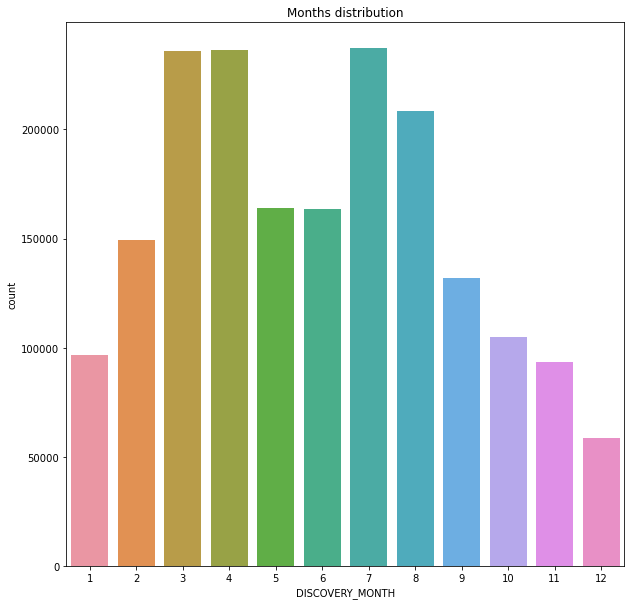

In [14]:
plt.figure(figsize=(10,10))
sns.countplot('DISCOVERY_MONTH' ,data=df).set(title="Months distribution")
plt.show()

/Users/avikogan/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


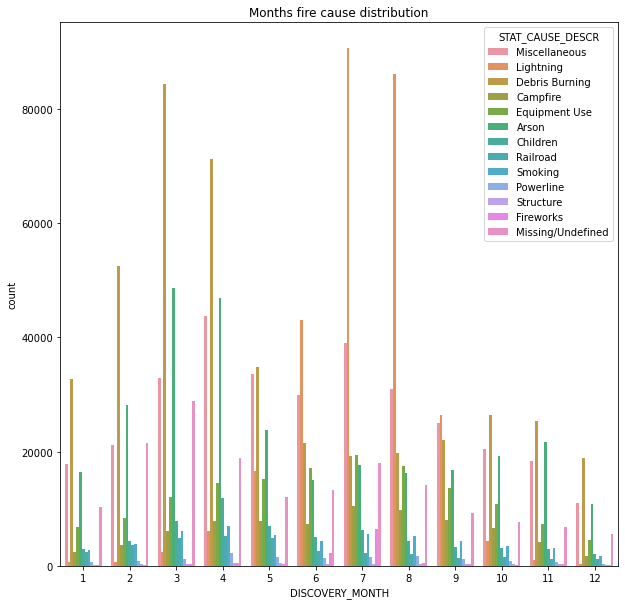

In [13]:
plt.figure(figsize=(10,10))
sns.countplot('DISCOVERY_MONTH', hue='STAT_CAUSE_DESCR' ,data=df).set(title="Months fire cause distribution")
plt.show()

# Total burn days
evalvalute the total time the fire burned.<br>
need to convert also 'CONT_DATE'

In [10]:
df['CONT_DATE_CONVERT'] = pd.to_datetime(df['CONT_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')

In [11]:
df['BURN_DAY'] = (df['CONT_DATE_CONVERT'] - df['DISCOVERY_DATE_CONVERT']).astype('timedelta64[D]')
df['BURN_DAY'] = df['BURN_DAY'].fillna(0) # fill missing values for the plot

In [12]:
df[['CONT_DATE_CONVERT', 'DISCOVERY_DATE_CONVERT', 'BURN_DAY', 'STATE']][df['BURN_DAY'] < 1]

,CONT_DATE_CONVERT,DISCOVERY_DATE_CONVERT,BURN_DAY,STATE
0,2005-02-02,2005-02-02,0.0,CA
1,2004-05-12,2004-05-12,0.0,CA
2,2004-05-31,2004-05-31,0.0,CA
7,2005-03-08,2005-03-08,0.0,CA
8,2005-03-15,2005-03-15,0.0,CA
...,...,...,...,...
1880460,2015-09-26,2015-09-26,0.0,CA
1880461,NaT,2015-10-05,0.0,CA
1880462,NaT,2015-05-02,0.0,CA
1880463,NaT,2015-10-14,0.0,CA


In [13]:
# check burn days means for each cause
burn_data = df.groupby('STAT_CAUSE_DESCR').agg({'BURN_DAY': [np.mean, np.median]})
burn_data # we can see that more than 50% of values are 0 - means they are missing. need to fill with other value.

BURN_DAY       
                       mean median
STAT_CAUSE_DESCR                  
Arson              0.285079    0.0
Campfire           0.573451    0.0
Children           0.155525    0.0
Debris Burning     0.162898    0.0
Equipment Use      0.189592    0.0
Fireworks          0.444348    0.0
Lightning          2.459482    0.0
Miscellaneous      0.687278    0.0
Missing/Undefined  0.213834    0.0
Powerline          0.579388    0.0
Railroad           0.125362    0.0
Smoking            0.489663    0.0
Structure          0.563488    0.0

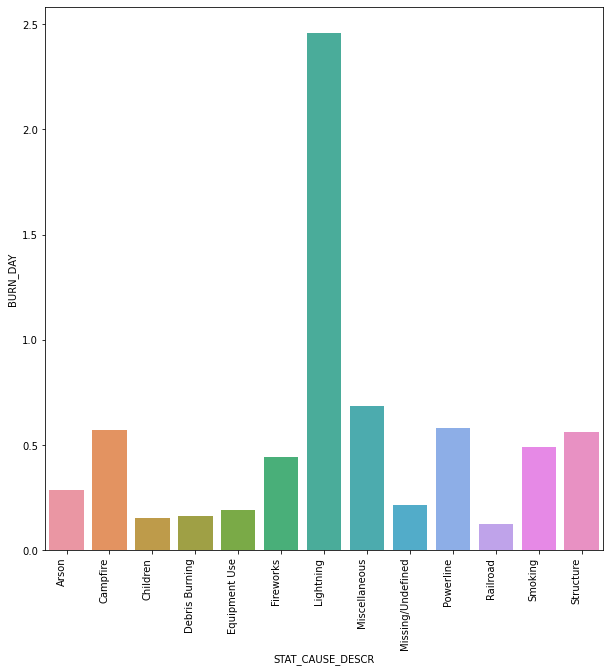

In [19]:
plt.figure(figsize=(10,10))
ax = sns.barplot(x=burn_data.index , y='BURN_DAY', data=burn_data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")  #it will rotate text on x axis
plt.show()

# Baseline

In [5]:
cont_cols = ['FIRE_SIZE', 'BURN_DAY', 'LATITUDE', 'LONGITUDE']
categorical_cols = ['DISCOVERY_DAY', 'DISCOVERY_MONTH', 'STATE', 'OWNER_DESCR', 'FIRE_YEAR']
rel_cols = cont_cols + categorical_cols
target = 'STAT_CAUSE_CODE'

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [14]:
X, y = df[rel_cols], df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

In [11]:
X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True) 

In [12]:
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True) 

In [13]:
missing_cols = set( X_train.columns ) - set( X_test.columns )
missing_cols # no missing.

set()

In [14]:
model_rf = RandomForestClassifier().fit(X_train, y_train)

In [16]:
pred = model_rf.predict(X_test)

In [17]:
from sklearn.metrics import f1_score
f1_score(y_test, pred, average=None)

array([0.78560497, 0.31817971, 0.08716058, 0.39965307, 0.59028109,
       0.47913984, 0.5404738 , 0.20115117, 0.50999652, 0.43369735,
       0.14078921, 0.05916187, 0.89881067])

In [22]:
f1_score(y_test, pred, average='weighted')

0.4573822899023221


In [21]:
# https://stackoverflow.com/questions/41900387/mapping-column-names-to-random-forest-feature-importances
def plot_feature_importance(m, features_names, n_top_features=None, model_name="Model"):
    if n_top_features is None:
        n_top_features = len(features_names)
    features_importance = pd.DataFrame(m.feature_importances_, features_names, columns=['importance'])
    top_features = features_importance.nlargest(n_top_features, columns=['importance'])
    ax = sns.barplot(x=top_features.index, y=top_features['importance'])
    ax.set_title(model_name + ' Features Importance')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")  #it will rotate text on x axis
    plt.show()

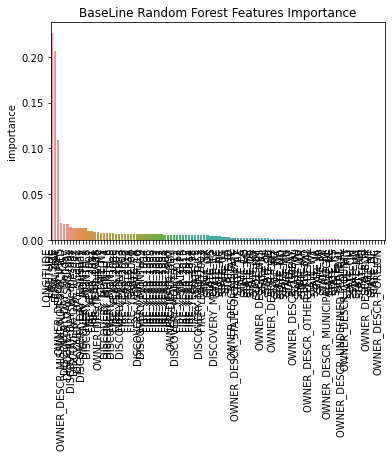

In [22]:
plot_feature_importance(model_rf, X_train.columns, model_name="BaseLine Random Forest")

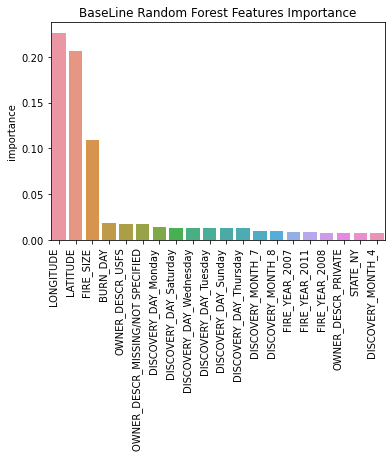

In [23]:
plot_feature_importance(model_rf, X_train.columns, model_name="BaseLine Random Forest", n_top_features=20)